In [ ]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
from matplotlib import cm
import umerc2025_utils as util
import wecopttool as wot
from capytaine.io.meshio import load_from_meshio
import os
from matplotlib.animation import FuncAnimation
# from IPython.display import clear_output
from IPython.display import display, HTML


## A Visual Exploration of Optimal Control in heaving WECs

### Daniel Gaebele, Giorgio Bacelli, Ryan Coe, Jeff Grasberger, Carlos Michelen Strofer
#### Sandia National Laboratories

inittially presented at UMERC 2025, Corvallis, OR (and since improved)
<img src=image.png alt="UMERC_OREC2025_logo" width="200"/>


### Theoretical Fundamentals

This work is partly inspired by the curves visualizing power as a function of WEC velocity magnitude, as Johannes Falnes presents them in his book *Ocean Waves and Oscillating Systems:
Linear Interactions Including Wave-Energy Extraction*.

These curves help us understand different forms of power as a function of WEC velocity amplitude $|\hat{u}|$ for linear systems in regular waves.
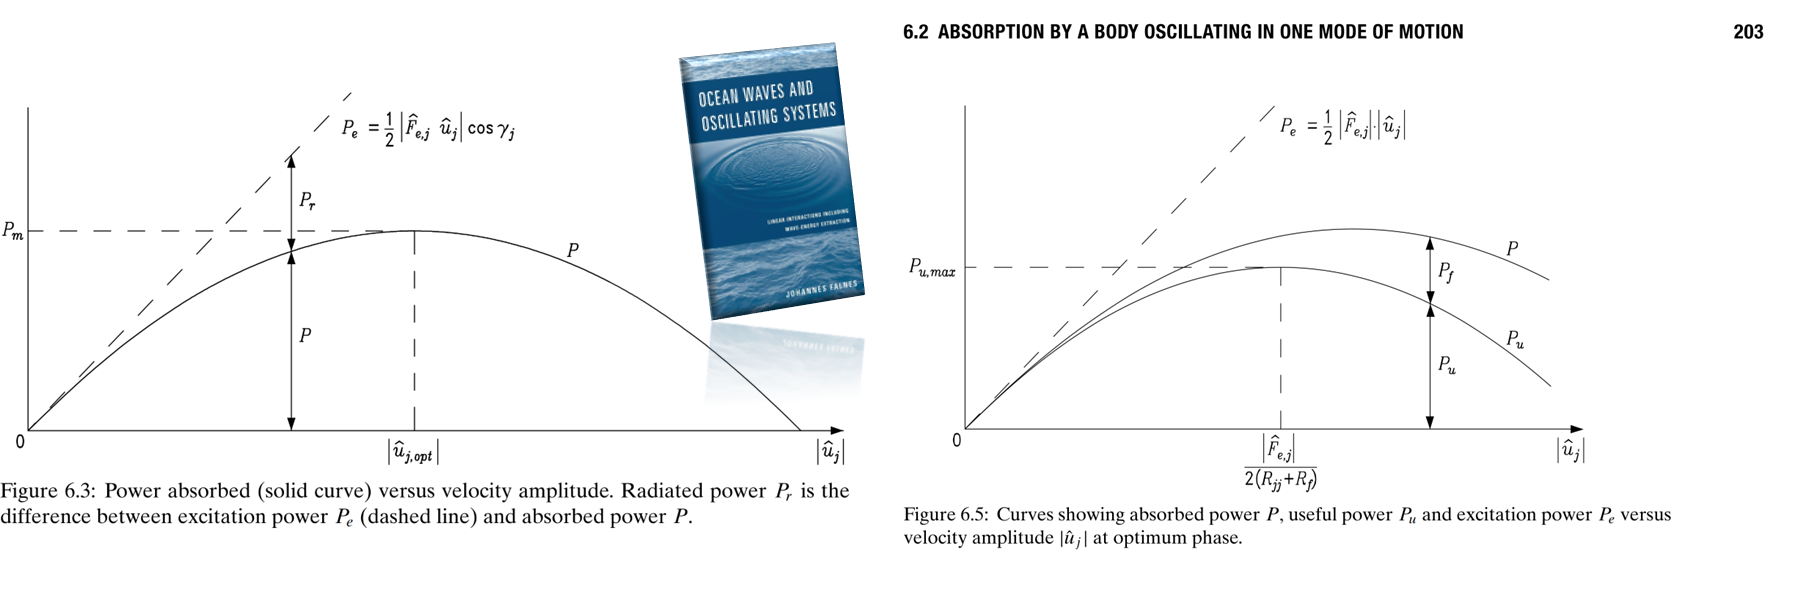

#### Key Takeaways:
- **Figure 6.3**:
    - There is an optimal average wave power absorbed ($P$) at an optimal $|\hat{u}|$. Later, we will refer to this as $\bar{P}_{abs}$.
    - At the optimal $|\hat{u}|$ the radiated power ($P_r$, or later $\bar{P}_{rad}$) is equal to the absorbed power 
        - This holds under the assumption of "optimum phase", where the wave excitation force is in phase with the WEC velocity.
        - We will see later that the optimum phase for wave absorption is not necessarily optimal for wave energy conversion into electricity.
- **Figure 6.5**
    -This figure considers friction (e.g., from PTO components), allowing the definition of average useful power  ($P_u$, or later $\bar{P}_{use}$) which accounts for dissipative losses.
    - The optimum velocity magnitude for useful power is smaller than the velocity magnitude for maximum power absorbed from the waves.

For an in-depth explanation, readers are referred to the original book:
[PDF download via researchgate (accessed on 08/26/2025)](https://www.researchgate.net/file.PostFileLoader.html?id=57683096b0366d3805062fb1&assetKey=AS%3A375115754819586%401466445973999).


### WaveBot Case Study
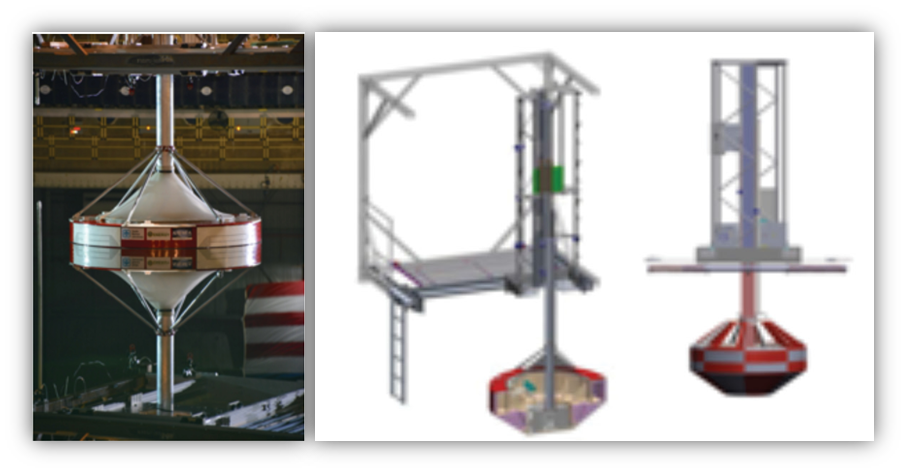

We will recreate these power curves and take them one step further by also considering electrical power, incorporating the PTO dynamics (including losses). For this case study, we will use the WaveBot as the WEC. More details on the models related to the WaveBot can be found in [Tutorial 1](https://github.com/sandialabs/WecOptTool/blob/main/examples/tutorial_1_WaveBot.ipynb).

#### Case Study overview
- **Waves**
    - A *single regular wave* with $f=0.3$ Hz, $A=0.1$m.
- **Ojective Functions**
    - *Power absorbed*: This corresponds to the "mechanical" power discussed in Tutorial 1. 
    - *Electrical power*: This accounts for the conversion of absorbed power into electricity, including PTO dynamics and losses.
- **PTO Configurations**
    - *Initial design*: The original PTO configuration. 
    - *Negative magnetic spring*: A modified PTO configuration incorporating a negative magnetic spring.

The markdown cells in this notebook will focus on the key takeaways from the plots rather than explaining all the code in detail.

In [ ]:
nsubsteps = 10   #substeps in time animation
n_steps = 15 #steps in power curves. Less steps is faster to compute
v_max = 1.0 #max enforced velocity for power curves
slow_down_ani = 4   #factor to slow down animation by

wavefreq = 0.3# Hz  #can alter, but presentation used 0.3Hz to show wave that's slower Zi minimum 


save_ani = False     #if True save animations as .gif locally
save_fig = False    #if True save figures as .png locally

In [ ]:
wot.set_loglevel('ERROR', capytaine=False)

results_dir = 'data'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
gfx_dir = 'gfx'
if not os.path.exists(gfx_dir):
    os.makedirs(gfx_dir)

In [ ]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 
mesh = wb.mesh(mesh_size_factor)

# create mesh object for WaveBot and add internal lid
mesh_obj = load_from_meshio(mesh, 'WaveBot')
lid_mesh = mesh_obj.generate_lid(-2e-2)

fb = cpy.FloatingBody(mesh=mesh_obj, lid_mesh=lid_mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

In [ ]:
#frequency vector to visualize the WaveBot's hydrodynamic impedance
f1 = 0.05
nfreq = 35
fname_string = 'bem_wavebot_f1_'+ str.replace(f'{f1}','.','p') +'Hz_nfreq'+ f'{nfreq}' +'.nc'

# freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequencyfname_string = 'bem_wavebot_f1_'+ str.replace(f'{freq[0]}','.','p') +'Hz_nfreq'+ f'{len()}' +'.nc'
fname_wec = os.path.join(results_dir, fname_string)
if os.path.exists(fname_wec):
    bem_data = wot.read_netcdf(fname_wec)
else:
    bem_data = wot.run_bem(fb, freq)
    wot.write_netcdf(fname_wec, bem_data)
hd = wot.add_linear_friction(bem_data, friction = None) 
hd = wot.check_radiation_damping(hd)
Zi = wot.hydrodynamic_impedance(hd)


We intentionally choose a regular wave at a frequency that is lower than the hydrodynamic resonance frequency of the WaveBot to demonstrate how difficult it is to have power flowing through the WEC if the mechanical components are not tuned in terms of Wave-to-Wire performance.


In [ ]:
fig, axes = wot.utilities.plot_bode_impedance(Zi)
[ax.axvline(wavefreq, linewidth = 2, color = 'cyan', label = 'Wave') for ax in axes.flatten()]
axes.flatten()[-1].legend()

For the remainder of this notebook, we will use a frequency vector that is substantially shorter for computational efficiency. Considering that we're using a linear system, we could theoretically optimize only for the regular wave frequency, but we chose the frequency vector to be future-ready to introduce nonlinearities either via dynamics or constraints. This frequency vector starts with the regular wave frequency and contains a few integer multiples of the wave frequency. Even nonlinear systems do not spill energy to frequencies that are not multiples of the fundamental frequency of excitation.


In [ ]:
f1 = wavefreq
nfreq = 5
amplitude = 0.1 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)
fname_string = 'bem_wavebot_f1_'+ str.replace(f'{f1}','.','p') +'Hz_nfreq'+ f'{nfreq}' +'.nc'

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequencyfname_string = 'bem_wavebot_f1_'+ str.replace(f'{freq[0]}','.','p') +'Hz_nfreq'+ f'{len()}' +'.nc'
fname_wec = os.path.join(results_dir, fname_string)
if os.path.exists(fname_wec):
    bem_data = wot.read_netcdf(fname_wec)
else:
    bem_data = wot.run_bem(fb, freq)
    wot.write_netcdf(fname_wec, bem_data)
hd = wot.add_linear_friction(bem_data, friction = None) 
hd = wot.check_radiation_damping(hd)
Zi = wot.hydrodynamic_impedance(hd)


#### Power Curves - Objective: Power Absorbed

We create the power curves numerically by enforcing a velocity magnitude with a dynamic constraint. The controller optimizes the velocity phase depending on the chosen objective function. For the first figure, we optimize for power absorbed with the initial PTO.

In [ ]:
Kms = 0 #no additional magnetic spring constant on the PTO
obj = 'abs' #objcetive funtion absorbed power
vel_targetd_vec = np.linspace(0.05, v_max, n_steps)
mag_vel, mag_current, P_load, P_ex, P_abs, P_use, p_flows = util.power_flows_per_vel(bem_data=bem_data, waves=waves, K_DT = Kms, obj_fun = obj,vel_targetd_vec = vel_targetd_vec)
fig, ax = util.plot_power_curves(bem_data=bem_data, waves=waves, K_DT=Kms,  obj_fun_string =obj, 
                       mag_vel= mag_vel, P_load = P_load, P_ex = P_ex, P_abs= P_abs, P_use=P_use, p_flows=p_flows)
ax.set_ylim([-100, 1000])

ax.legend()
if save_fig:
    fig_name = f'power_curve_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}.png'
    plt.savefig(os.path.join(gfx_dir, fig_name))
plt.show()


Please note that in the figure above, there is only a very small velocity magnitude range in which we would convert electrical power (and not expend it in order to achieve the velocity phase that helps us absorb the most power from the waves.)

This is clearly not what we want for a WEC... 

So, let's use WecOptTool to optimize the controller and the WEC trajectory for electrical power.

#### Power Curves - Objective: Electrical Power


In [ ]:
Kms = 0 #no additional magnetic spring constant on the PTO
obj = 'elec' #objcetive funtion electrical power
vel_targetd_vec = np.linspace(0.05, v_max, n_steps)
mag_vel, mag_current, P_load, P_ex, P_abs, P_use, p_flows = util.power_flows_per_vel(bem_data=bem_data, waves=waves, K_DT = Kms, obj_fun = obj,vel_targetd_vec = vel_targetd_vec)
fig, ax  = util.plot_power_curves(bem_data=bem_data, waves=waves, K_DT=Kms,  obj_fun_string =obj, 
                       mag_vel= mag_vel, P_load = P_load, P_ex = P_ex, P_abs= P_abs, P_use=P_use, p_flows=p_flows)
ax.set_ylim([-100, 1000])

vline_elec = ax.plot([vel_targetd_vec[np.argmax(P_load)]]*2, [0, P_ex[np.argmax(P_load)]], color='black', linestyle='--', alpha=0.5, label='Opt. Elec')
# vline_abs = ax.plot([vel_targetd_vec[np.argmax(P_abs)]]*2, [0, P_ex[np.argmax(P_abs)]], color='black', linestyle=':', alpha=0.5, label='Opt. Abs (for min $P_{elec}$)')

ax.text(vel_targetd_vec[np.argmax(P_load)], P_ex[np.argmax(P_load)], 'Opt. $P_{elec}$',
            ha="center", va="bottom", rotation=90, size=10,
            bbox=dict(boxstyle="round,pad=0.3",
                      fc=util.power_flow_colors()['elec'], ec="None",alpha = 0.2, lw=1))


if save_fig:
    fig_name = f'power_curve_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}.png'
    plt.savefig(os.path.join(gfx_dir, fig_name))
plt.show()


Now is a good time to introduce the semi-transparent vertical bars. They show reference power values for optimal absorbed power (see Falnes for the analytical derivation). Even though there is a controller considered that reached the optimal velocity magnitude, we didn't absorb the theoretically possible power because velocity and excitation force are not in phase.

In other words, if we want to bring the WEC velocity in phase with the excitaiton force we would have needed to *expend* even more electrical power. 

So, did we achieve our initial goal of being able to convert more electrical power from the waves?

Yes! But, the peak of the electrical power curve $P_{elec}$  is still dissapointingly low compared to the theoretically optimal absorbed power.

Let's look at the power flows at the optimal velocity magnitude for electrical power "Opt. $P_{elec}$" relative to the optimal reference value for absorbed power in the next figure to gain a deeper understanding of the power flow in and through our WEC.

#### Sankey avergae power flow diagram for optimal electrical power


In [ ]:
target_vel = None   # By not enforcing a velocity magnitude, the solution will be the optimal
wec, pto, results = util.wec_pto_and_res_enforced_vel(bem_data = bem_data,
                                                         waves = waves,
                                                         fd_vel_target = target_vel,
                                                         K_DT= Kms, 
                                                         obj_fun= 'elec',
                                                         )
p_flows = util.calculate_power_flows(wec, pto, results, waves, Zi)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
util.plot_power_flow(p_flows)

if save_fig:
    fig_name = f'power_flow_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}_target_vel_{target_vel}.png'
    plt.savefig(os.path.join(gfx_dir, fig_name))
plt.show()

In this Sankey power flow diagram, we present the same quantities as in the power curve plots above, but focus on a single velocity value. Effectively, we slice all the power curves at the peak of the electrical power "Opt. $P_{elec}$". 
- The curves' y-values are now visualized as arrows flowing from left to right.
- The differences between consecutive curves are depicted as downward-pointing arrows, representing the power that was not converted to the next stage.

We learn that although we have significant electrical losses, that the deficit in absorbed power is many times larger. 
We already know from the power curves that we can't absorb more wave power without jeopardizing the electrical power. 
In other words, with control only, we can't achieve power flowing into _and_ through the WEC.

In the following sections we answer in more detail
- Why we can't absorb more with control without losing out on electrical power
- If active control can't get us more power flowing into the WEC, what could?

#### Dynamic Animations: Powers and State Space

The final type of visualizations used in this work are animations that connect average power flows to instantaneous dynamics.

- Left-hand side of the animations:
    - The two-port network represents a simple model of the WaveBot. From left to right:
        - First loop: The excitation (source) and the intrinsinc impedance $Z_i$.
        - Second loop: The geared drivetrain converting linear to rotary motion with ratio $N$ and drivetrain impedance $Z_d$.
        - Third loop: The generator converting rotary motion to current with torque constant $k_{\tau}$ and winding impedance $Z_w$.
        - The control is represented as load with impedance $Z_{\ell}$.
    - The power bars are located at their respective WEC component
        - Fully opaque arrows represent the average power flows.
        - The respective instantaneous power is shown in the background of the arrows, visualized with moving semi-transparent bars.
    - The WaveBot hull
        - The hull shape follows the instantaneous position, thus also indicates the instantaneous velocity.
        - At the origin of the hull we visualize the instantaneous force that acts on the hull due to the PTO.

- Right-hand side of the animations:
    - A 3-dimensional phase space is plotted.
        - The horizontal plane represents the system states: position and velocity.
        - The vertical axis represents the control state: the PTO (Power Take-Off) force.
    - A marker indicates the instantaneous 3D state, orbiting along the solid phase-space trajectory.
    - The darker dashed trajectory is the projection of the solid trajectory into the velocity-force plane.
        - In this plane, we visualize a loss surface, which in this simplified model is a quadratic paraboloid.
        - For the WaveBot, losses associated with high force dominate. The force is proportional to the motor current, and these high losses are notable despite the WaveBot deploying a generator with very low winding resistance ($R_w=0.5 \Omega$).

**We learn that when optimizing for electrical power, the optimal trajectory avoids areas of high loss!**

In [ ]:
p_tdom = pto_tdom
w_tdom = wec_tdom
time = p_tdom.time
animation  = util.create_wb_animation(wec, pto, w_tdom=w_tdom, p_tdom=p_tdom, waves=waves,K_DT=Kms,  obj_fun_string =obj, wb=wb, slow_down_ani =slow_down_ani)
if save_ani:
    animation_string = f'animation_wavebot_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}_target_vel_{target_vel}_slow_mo_{slow_down_ani}.gif'
    fname_animation = os.path.join(gfx_dir, animation_string)
    animation.save(fname_animation, writer='pillow', fps = 1 / (slow_down_ani*(time[1]-time[0])))
else:
    display(HTML(animation.to_jshtml()))
plt.close()

Now, let us look more closely into why control alone can't provide effective power flow.

#### Forcing the WEC to operate at the optimal velocity magnitude

For this next example, we want to _absorb_ more power than before. We do so by forcing the WEC to operate at the velocity magnitude that is optimal for maximizing the wave power absorbed, i.e., the velocity magnitude indicated by semi-transparent vertical bars in the power curves figure. We still use the electrical power as objective function. This means that we will minimize the electrical power required to achieve the target velocity magnitude. We'll learn what this implies for the other average power flows:

In [ ]:
target_vel = util.opt_vel_mag(bem_data, waves)  #our target velocity is the optimal velocity magnitude.
wec, pto, results = util.wec_pto_and_res_enforced_vel(bem_data = bem_data,
                                                         waves = waves,
                                                         fd_vel_target = target_vel,
                                                         K_DT= Kms, 
                                                         obj_fun= 'elec',
                                                         )
p_flows = util.calculate_power_flows(wec, pto, results, waves, Zi)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)

util.plot_power_flow(p_flows)
if save_fig:
    fig_name = f'power_flow_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}_target_vel_{target_vel}.png'
    plt.savefig(os.path.join(gfx_dir, fig_name))
plt.show()


This Sankey plot shows us that we actually _expend_ **Electrical Power**! The yellow arrow goes from left to right, which means electrical power flows _into_ the system.
We further learn that the **Radiated Power** is optimal because it is 1/2 of the **Optimal Excitation**. This means that we achieved our optimal velocity magnitude.
However, we also see that we have not absorbed the maximal power (based on the WaveBot's hull radiation and excitation properties). There is still a substantial **Deficit Absorbed**. 
This implies that we have only met the optimal amplitude condition and not the optimal phase condition for **Absorbed Power**.

WecOptTool, in its nature as optimization code, gave us the solution that requires the least electrical power in order to achieve the targeted velocity magnitude of the hull's motion.

Now, let's look at a dynamic animation again to understand why we have to expend so much electrical power.

In [ ]:

p_tdom = pto_tdom
w_tdom = wec_tdom
time = p_tdom.time
animation  = util.create_wb_animation(wec, pto, 
                                      w_tdom=w_tdom,
                                      p_tdom=p_tdom,
                                      waves=waves,
                                      K_DT=Kms,
                                      obj_fun_string =obj,
                                      wb=wb,
                                      slow_down_ani =slow_down_ani,
                                      sup_title='Enforced velocity magnitude')
if save_ani:
    animation_string = f'animation_wavebot_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}_target_vel_{target_vel}_slow_mo_{slow_down_ani}.gif'
    fname_animation = os.path.join(gfx_dir, animation_string)
    animation.save(fname_animation, writer='pillow', fps = 1 / (slow_down_ani*(time[1]-time[0])))
else:
    display(HTML(animation.to_jshtml()))
plt.close()

The red arrow for $P_{elec}$ shows that, on average, we had to expend electrical power. The semi-transparent instantaneous $P_{elec}$ is very negative at time of a large control force.
The orbit in the phase space is heavily tilted relative to the WEC position. This implies a high _integral gain_ $K_i$, often referred to as reactive power.
Here, the control force has a much higher amplitude compared to the solution for optimal electrical power, and the loss plane (x-z) shows us that the times spent at high force are associated with high losses!

In other words, the reactive mechanical power that the hull needs to reach the optimal velocity amplitude conditions requires much more electrical power, because it comes with the price of high losses!


For educational purposes, let's take this one step further and force our WEC to absorb the maximal amount of wave power by setting the objective function to **Absorbed Power**.
This results in a solution that is often referred to as _complex conjugate_ control and ensures that both the phase and amplitude conditions for absorbing wave power are met.

In [ ]:
target_vel = None 
obj = 'abs'
Kms = 0
wec, pto, results = util.wec_pto_and_res_enforced_vel(bem_data = bem_data,
                                                         waves = waves,
                                                         fd_vel_target = target_vel,
                                                         K_DT= Kms, 
                                                         obj_fun= obj,
                                                         )
p_flows = util.calculate_power_flows(wec, pto, results, waves, Zi)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
util.plot_power_flow(p_flows)
if save_fig:
    fig_name = f'power_flow_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}_target_vel_{target_vel}.png'
    plt.savefig(os.path.join(gfx_dir, fig_name))
plt.show()


We see that now the **Absorbed Power** is half of the **Optimal Excitation**, which is the upper limit for a symmetric point absorber oscillating in heave.

From the dynamics, we see that the required forces to achieve this WEC trajectory are even higher, and consequently so are the associated losses.

In [ ]:
p_tdom = pto_tdom
w_tdom = wec_tdom
time = p_tdom.time
animation  = util.create_wb_animation(wec, pto, w_tdom=w_tdom, p_tdom=p_tdom, waves=waves,K_DT=Kms,  obj_fun_string =obj, wb=wb, slow_down_ani =slow_down_ani)
if save_ani:
    animation_string = f'animation_wavebot_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}_target_vel_{target_vel}_slow_mo_{slow_down_ani}.gif'
    fname_animation = os.path.join(gfx_dir, animation_string)
    animation.save(fname_animation, writer='pillow', fps = 1 / (slow_down_ani*(time[1]-time[0])))
else:
    display(HTML(animation.to_jshtml()))
plt.close()

So, does that mean we can't effectively capture and convert energy for an oscillating WEC with a hydrodynamic resonance frequency that is faster than the wave frequency?

_At least not with **control** using an electric machine as generator **and** a motor_.


This is not a new realization and led to adaptation of the multi-port network framework for WECs to account for their PTO dynamics in simple linear models:
https://doi.org/10.1016/j.mechatronics.2025.103395
In this paper we explain in more detail why it is important to match the impedance at the input and output of the PTO and illustrate why this requires design alterations of the PTO for the WaveBot, with the controller taking those alterations into account.

Everything we looked at so far only concerned different control schemes. 
- First, we looked at the power curves as a function of the velocity magnitude for controllers that have electrical and absorbed power as objective.
- Second, we perfectly matched the output impedance when we optimized the controller for average electrical power.
- Third, we improved the input impedance matching, while giving some attention to the output by enforcing the optimal velocity magnitude for absorbed power and while minimizing the average electrical power we had to expend.
- Lastly, we achieved input matching (often referred to as complex conjugate control) by optimizing for absorbed power at the cost of expending even more electrical power.

Next, we will illustrate how a component with negative stiffness has the effect of improving impedance match-
ing on the input port at lower frequencies. In the paper, similar effects for a flywheel are also demonstrated.



## Magnetick Spring 

This tunable magnetic spring was developed by PSU and tested on the WaveBot at Maneuvering and Seakeeping Basin (MASK). The interested user is referred to https://mhkdr.openei.org/submissions/518 

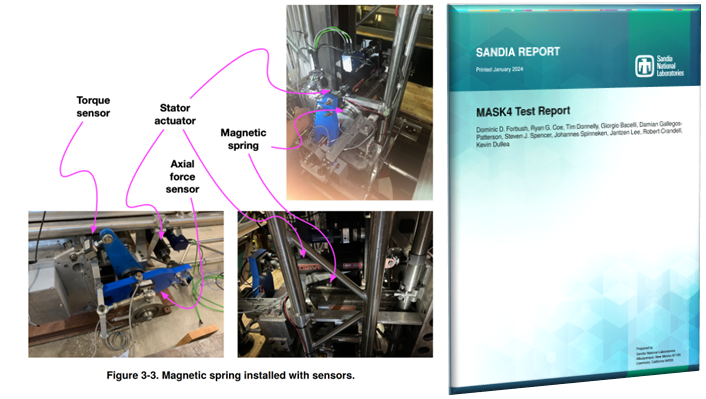

In the next animations, we illustrate how the power curves change for different values of magnetic spring stiffness. We start from a positive stiffness (which could be achieved with simple mechanical springs) to negative stiffness values, which cause a destabilization of the total system. 
The next cells might take a few minutes to execute. 

In [ ]:
Kms_vec = np.linspace(50, -150, 25)


In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
def init_func():
    ax.clear()
    u_opt_abs = util.opt_vel_mag(bem_data, waves)
    clrs = util.power_flow_colors()
    ax.plot([u_opt_abs, u_opt_abs],[0, 2*p_flows['Max Absorbed']],  
        solid_capstyle="butt", #no projections with line width 
                color=clrs['exc'], linewidth=10, alpha = 0.2, label = 'Opt. Exc.')
    ax.plot([u_opt_abs, u_opt_abs],[p_flows['Max Absorbed'], 2*p_flows['Max Absorbed']],  
        solid_capstyle="butt", #no projections with line width 
                color=clrs['rad'], linewidth=4, alpha = 0.6, label = 'Opt. Rad.')
    ax.plot([u_opt_abs, u_opt_abs],[0, p_flows['Max Absorbed']],  
        solid_capstyle="butt", #no projections with line width 
                color=clrs['abs'], linewidth=4, alpha = 0.6, label = 'Max. Abs.')
    ax.set_title(f'DT stiff {Kms:.0f} Nm/rad, objective fun.: {obj}')
    ax.set_xlabel('Velocity magnitude, $|u|$ [m/s]')
    ax.set_ylabel('Power [W]')
    ax.legend()


def animate_power_curves(frame):
    ax.clear()  # Clear the current axes
    Kms = Kms_vec[frame]
    obj = 'elec'
    vel_targetd_vec = np.linspace(0.05, v_max, n_steps)
    mag_vel, mag_current, P_load, P_ex, P_abs, P_use, p_flows = util.power_flows_per_vel(bem_data=bem_data, waves=waves, K_DT = Kms, obj_fun = obj,vel_targetd_vec = vel_targetd_vec, verbose=False)

    clrs = util.power_flow_colors()

    plt.tight_layout
    ax.plot(mag_vel, P_ex, c = clrs['exc'], label ='$P_{{exc}}$')
    ax.plot(mag_vel, P_abs, c = clrs['abs'], label ='$P_{{abs}}$')
    ax.plot(mag_vel, P_use, c = clrs['use'], label ='$P_{{use}}$')
    ax.plot(mag_vel, P_load, c = clrs['elec'], label ='$P_{{elec}}$')
    u_opt_abs = util.opt_vel_mag(bem_data, waves)
    ax.plot([u_opt_abs, u_opt_abs],[0, 2*p_flows['Max Absorbed']],  
        solid_capstyle="butt", #no projections with line width 
                color=clrs['exc'], linewidth=10, alpha = 0.2, label = 'Opt. Exc.')
    ax.plot([u_opt_abs, u_opt_abs],[p_flows['Max Absorbed'], 2*p_flows['Max Absorbed']],  
        solid_capstyle="butt", #no projections with line width 
                color=clrs['rad'], linewidth=4, alpha = 0.6, label = 'Opt. Rad.')
    ax.plot([u_opt_abs, u_opt_abs],[0, p_flows['Max Absorbed']],  
        solid_capstyle="butt", #no projections with line width 
                color=clrs['abs'], linewidth=4, alpha = 0.6, label = 'Max. Abs.')
    ax.set_title(f'DT stiff {Kms:.0f} Nm/rad, objective fun.: {obj}')
    ax.set_xlabel('Velocity magnitude, $|u|$ [m/s]')
    ax.set_ylabel('Power [W]')
    ax.legend()

    ax.set_ylim([-100, 1000])
    ax.grid()

animation = FuncAnimation(fig, animate_power_curves, frames=len(Kms_vec), init_func=init_func, interval=500, repeat_delay = 1000)

if save_ani:
    animation_string = f'animation_power_curve_with_spring_{wavefreq:.2}Hz_obj_fun_{obj}.gif'
    fname_animation = os.path.join(gfx_dir, animation_string)
    animation.save(fname_animation, writer='pillow', fps = 1 / (slow_down_ani* (time[1]-time[0])))
else:
    display(HTML(animation.to_jshtml()))
plt.close()

For this single regular wave, we see that the improvements in the electrical power curve are substantial!

We also expect a clear optimum in terms of average electrical power for the drivetrain stiffness.

The Sankey average power flow diagrams reveal how the losses shift from electrical to mechanical with increasing negative drivetrain stiffness. This implies that the destabilizing magnetic spring enables the WEC to oscillate with a higher velocity magnitude without requiring much reactive power from the electric machine.

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols= 1,
                tight_layout=True, 
                figsize= [8, 4])
def animate_power_flows(frame):
    axes.clear()  # Clear the current axes
    Kms = Kms_vec[frame]
    obj = 'elec'
    target_vel = None
    wec, pto, results = util.wec_pto_and_res_enforced_vel(bem_data = bem_data,
                                                            waves = waves,
                                                            fd_vel_target = target_vel,
                                                            K_DT= Kms, 
                                                            obj_fun= 'elec',
                                                            verbose= False
                                                            )
    p_flows = util.calculate_power_flows(wec, pto, results, waves, Zi)
    util.plot_power_flow(p_flows, axes=axes, axes_title=f'DT stiff {Kms:.0f} Nm/rad, objective fun.: {obj}')

animation = FuncAnimation(fig, animate_power_flows, frames=len(Kms_vec), init_func=init_func, interval=500, repeat_delay = 1000)
if save_ani:
    animation_string = f'animation_power_flowe_with_spring_{wavefreq:.2}Hz_obj_fun_{obj}.gif'
    fname_animation = os.path.join(gfx_dir, animation_string)
    animation.save(fname_animation, writer='pillow', fps = 1 / (slow_down_ani* (time[1]-time[0])))
else:
    display(HTML(animation.to_jshtml()))
plt.close()

Now, let us look at the optimal magnetic spring stiffness below and the power curves associated with this PTO configuration.

The electrical power curve approaches the useful power curve for high velocity magnitudes, and their respective maxima are at a much higher velocity amplitude compared to the PTO without the magnetic spring. Now, the magnetic spring causes effective power flow into the PTO, allowing the control to focus on delivering the power to the load.

In [ ]:
Kms = -109.4
obj = 'elec'
vel_targetd_vec = np.linspace(0.05, v_max, n_steps)
mag_vel, mag_current, P_load, P_ex, P_abs, P_use, p_flows = util.power_flows_per_vel(bem_data=bem_data, waves=waves, K_DT = Kms, obj_fun = obj,vel_targetd_vec = vel_targetd_vec, verbose = False)
fig, ax = util.plot_power_curves(bem_data=bem_data, waves=waves, K_DT=Kms,  obj_fun_string =obj, 
                       mag_vel= mag_vel, P_load = P_load, P_ex = P_ex, P_abs= P_abs, P_use=P_use, p_flows=p_flows)
ax.set_ylim([-100, 1000])
if save_fig:
    fig_name = f'power_curve_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}.png'
    plt.savefig(os.path.join(gfx_dir, fig_name))
plt.show()


Based on the Sankey average power flow diagram, it becomes evident that the optimal trajectory with the optimal magnetic spring stiffness is close to absorbing the maximal amount of wave power, but at a much lower radiation. In theory, we could absorb 10.6 W more, but we would need to radiate an additional 112 W.


In [ ]:
wec, pto, results = util.wec_pto_and_res_enforced_vel(bem_data = bem_data,
                                                         waves = waves,
                                                         fd_vel_target = None,
                                                         K_DT= Kms, 
                                                         obj_fun= obj,
                                                         )
p_flows = util.calculate_power_flows(wec, pto, results, waves, Zi)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
util.plot_power_flow(p_flows)
if save_fig:
    fig_name = f'power_flow_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}_target_vel_{target_vel}.png'
    plt.savefig(os.path.join(gfx_dir, fig_name))
plt.show()


The dynamic animation shows us that the buoy reaches a large motion amplitude and that the force due to the magnetic spring is much higher compared to the force directly coming from the generator control.

If we look at the phase space, we can see that it is still a large orbit, but the control force is not tilted as much anymore. Additionally, in the velocity-force plane, the projection approaches a line (which would represent pure damping).

In [ ]:
p_tdom = pto_tdom
w_tdom = wec_tdom
time = p_tdom.time
animation  = util.create_wb_animation(wec, pto, w_tdom=w_tdom, p_tdom=p_tdom, waves=waves,K_DT=Kms,  obj_fun_string =obj, wb=wb, slow_down_ani =slow_down_ani)

if save_ani:
    animation_string = f'animation_wavebot_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}_target_vel_{target_vel}_slow_mo_{slow_down_ani}.gif'
    fname_animation = os.path.join(gfx_dir, animation_string)
    animation.save(fname_animation, writer='pillow', fps = 1 / (slow_down_ani* (time[1]-time[0])))
else:
    display(HTML(animation.to_jshtml()))
plt.close()

Now, we recognize that the trajectory still looks quite dramatic considering that the WaveBot is almost fully submerged or leaving the water. While the linear models are still surprisingly valid in these modes of operation, the practical amount of energy density of an energy storage component (such as the magnetic spring) might be prohibitive to the theoretically optimal solution that we obtain numerically.

Aside from the fact that we can combine different types of energy storage (potential and inertial), an engineering solution would likely be a compromise between different objectives such as average electrical power, loading on the components, and cost.

For illustration purposes, in the next few cells, we show the same plots with a somewhat arbitrary negative magnetic spring stiffness that causes the mechanical and electrical losses to be approximately equal to each other. This PTO design compromises between average electrical power and large oscillation amplitude and forces.

In [ ]:
Kms = -78
obj = 'elec'
vel_targetd_vec = np.linspace(0.05, v_max, n_steps)
mag_vel, mag_current, P_load, P_ex, P_abs, P_use, p_flows = util.power_flows_per_vel(bem_data=bem_data, waves=waves, K_DT = Kms, obj_fun = obj,vel_targetd_vec = vel_targetd_vec)
fig, ax = util.plot_power_curves(bem_data=bem_data, waves=waves, K_DT=Kms,  obj_fun_string =obj, 
                       mag_vel= mag_vel, P_load = P_load, P_ex = P_ex, P_abs= P_abs, P_use=P_use, p_flows=p_flows)
ax.set_ylim([-100, 1000])
if save_fig:
    fig_name = f'power_curve_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}.png'
    plt.savefig(os.path.join(gfx_dir, fig_name))
plt.show()


In [ ]:
wec, pto, results = util.wec_pto_and_res_enforced_vel(bem_data = bem_data,
                                                         waves = waves,
                                                         fd_vel_target = None,
                                                         K_DT= Kms, 
                                                         obj_fun= obj,
                                                         )
p_flows = util.calculate_power_flows(wec, pto, results, waves, Zi)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
util.plot_power_flow(p_flows)
if save_fig:
    fig_name = f'power_flow_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}_target_vel_{target_vel}.png'
    plt.savefig(os.path.join(gfx_dir, fig_name))
plt.show()


In [ ]:
p_tdom = pto_tdom
w_tdom = wec_tdom
time = p_tdom.time
animation  = util.create_wb_animation(wec, pto, w_tdom=w_tdom, p_tdom=p_tdom, waves=waves,K_DT=Kms,  obj_fun_string =obj, wb=wb, slow_down_ani =slow_down_ani)

if save_ani:
    animation_string = f'animation_wavebot_wavefreq_{wavefreq:.2}Hz_Kms_{Kms:.1f}_obj_fun_{obj}_target_vel_{target_vel}_slow_mo_{slow_down_ani}.gif'
    fname_animation = os.path.join(gfx_dir, animation_string)
    animation.save(fname_animation, writer='pillow', fps = 1 / (slow_down_ani* (time[1]-time[0])))
else:
    display(HTML(animation.to_jshtml()))
plt.close()